Najpierw importujemy biblioteki wykorzystywane w tym notebooku:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

Definiujemy przydatne funkcje omawiane w poporzednich notebookach:

In [ ]:
def periodogram(s, okno , F_samp):
    '''peiodogram sygnału s
    okno - synał będzie przez nie przemnożony w czasie
    F_samp- częstość próbkowania'''
    okno = okno/np.linalg.norm(okno)
    s = s*okno
    N_fft = len(s)
    S = np.fft.rfft(s,N_fft)
    P = S*S.conj()   
    P = P.real/Fs # P i tak ma zerowe wartości urojone, ale trzeba ykonać konwersję typów
    F = np.fft.rfftfreq(N_fft, 1/F_samp)
    if len(s)%2 ==0: # dokładamy moc z ujemnej części widma 
        P[1:-1] *=2
    else:
        P[1:] *=2
    return (F,P)

# Procesy AR
## Dla przypomnienia: 

proces AR generowany jest tak, że kolejna próbka jest ważoną sumą $p$ poprzednich próbek i niezależnej zmiennej losowej o średniej 0 i wariancji $\sigma^2$:

$x[n] = \sum_{k=1}^p a[k] * x[n-k] +\varepsilon[n]$

i $\varepsilon[n] \sim N(0,\sigma^2)$


Proces AR można zatem scharakteryzować podając:
* współczynniki $a$ oraz 
* $\sigma^2$. 

## Zadanie: ilustracja realizacji procesu ##
Poniższy kod po uzupełnieniu będzie ilustrował jak mogą wyglądać pojedyncze realizacje procesu opisywanego przez: 
* współczynniki:

In [ ]:
a=[0.9, -0.7]  #[0.9, -0.1] #

* wariancję $\sigma^2 = 1$:

In [ ]:
sigma = 4

Teraz definiujemy funkcję, która wytwarza jedną realizację procesu:

In [ ]:
def realizacjaAR(a,sigma, N):
    '''
    a: współczynniki 
    sigma: standardowe odchylenie
    N: liczba próbek w realizacji
    '''
    x = np.zeros(N)
    for i in range(2,N): #kolejno tworzymy próbki w realizacji
        x[i]=a[0]*x[i-1]+a[1]*x[i-2]+ np.random.randn(1)*sigma
    return x
  

Wykorzystajmy tą funkcję do wytworzenia 5 realizacji po 500 próbek każda:

In [ ]:
N_realizacji = 5 # liczba realizacji
N = 500 #liczba punktów w realizacji

realizacja = np.zeros((N_realizacji, N)); # macierz na wszystkie realizacje
for r in range(0,N_realizacji):    #generujemy realizacje procesu
    realizacja[r,:] = realizacjaAR(a,sigma, N)

Wykreślmy te realizacje:

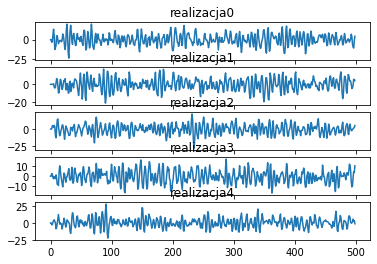

In [ ]:
import matplotlib.pyplot as plt

for r in range(0,N_realizacji):   #rysujemy realizacje procesu
    plt.subplot(5,1,r+1)
    plt.plot(realizacja[r,:])
    plt.title('realizacja'+str(r))
plt.show()

## Zadanie: ilustracja funkcji autokorelacji procesu
Dla współczynników  $a$, dla których proces ten jest stacjonarny,  charakteryzuje się on też pewną konkretną funkcją autokorelacji. 
Poniższe ćwiczenie powinno nam uświadomić:
* jak może wyglądać estymowana funkcja autokorelacji dla realizacji procesu AR
* jak estymata funkcji autokorelacji zależy od długości realizacji (czyli od ilości dostępnych informacji). Co dzieje się z funkcją autokorelacji dla poszczególnych realizacji, gdy zwiększamy liczbę punktów w realizacji _N_ od 50 do 5000? **Uwaga:** dla każdej zmiany _N_ musimy wygenerować nowe realizacje o tej długości 


In [ ]:
legenda =[]
for r in range(0,N_realizacji):   #rysujemy funkcję autokorelacji poszczególnych realizacji
    f_corr = np.correlate(realizacja[r,:],realizacja[r,:],'full')# ...
    tau = np.arange(-N+1,N,1)
    ind = range(...-10,...+10) # tu szykujemy indeksy, dzięki którym będziemy mogli pobrać wycinek +/- 10 próbek wokół przesunięcia 0 
    plt.plot(tau[ind],f_corr[ind])
    legenda.append(r)
plt.title('fragment funkcji autokorelacji')
plt.legend(legenda)
plt.show()

In [ ]:
a = [      1, 2, 3]
b = [            2 ,1, 2]
print(1*2 + 2*1 +3*2)
print(np.correlate(a,b,'valid'))

print(np.correlate(a,b,'same'))
print([ 1*1 + 2*2, 
       1*2 + 2*1 +3*2, 
       2*2 + 3*1])

print(np.correlate(a,b,'full'))
print([2*1, 
       1*1 + 2*2, 
       1*2 + 2*1 +3*2, 
       2*2 + 3*1,
       3*2])

10
[10]
[ 5 10  7]
[5, 10, 7]
[ 2  5 10  7  6]
[2, 5, 10, 7, 6]


# Model AR
Rozważania na temat procesów AR są o tyle interesujące, że wiele sygnałów, które chcielibyśmy badać całkiem nieźle daje się opisać jako procesy AR.
Wyobrażamy sobie wówczas, że rejestrowane sygnały są generowane przez pewien model AR (trochę tak jak funkcja realizacjaAR wytwarzała pojedyncze realizacje procesu). Pojawia się w tym momencie pytanie: jak możemy poznać wartości parametrów $a$ i $\sigma^2$, które *pasują* do badanych sygnałów?

## Estymacja parametrów
Algorytmów służących do estymacji parametrów modelu AR jest kilka. Tu przedstawimy algorytm Yule-Walker'a: 
* mnożymy stronami równania opisujące proces dla póbki $t$ i $t-m$

  $x_t x_{t-m} = \sum _{i=1}^p a_i x_{t-i} x_{t-m} +\epsilon _t x_{t-m} $

* bierzemy **wartość oczekiwaną** lewej i prawej strony. Wartości oczekiwane $E\lbrace x_t x_{t-m}\rbrace$ to funkcja autokorelacji $R(m)$ więc:

  $R(m) = \sum _{i=1}^p a_i R(m-i)+ \sigma _\epsilon ^2 \delta (m)$

  gdzie $m=0,\dots ,p.$

* Dla $m>0$ możemy zapisać stąd układ równań:

  $\left[\begin{array}{c}
R(1)\\
R(2)\\
\vdots \\
R(p)
\end{array}\right]=
\left[\begin{array}{cccc}
R(0)& R(-1) &\dots &\\
R(1)& R(0) &R(-1) \dots &\\
\vdots & & &\\
R(p-1) & &\dots &R(0)
\end{array}\right] \left[\begin{array}{c}
a_1\\
a_2\\
\vdots \\
a_p
\end{array} \right] $

* stąd wyliczamy współczynniki $a$, 

* dla $m=0$ mamy

  $R(0) = \sum _{k=1}^p a_k R(-k) + \sigma _\epsilon ^2$

* można stąd wyliczyć $\sigma _\epsilon ^2 $

**Uwaga:** w powyższym wyprowadzeniu występuje operacja brania wartości oczekiwanej iloczynu $x_t*x_{t-m}$. Funkcja `numpy.correlate` oblicza dla każdego przesunięcia $m$ sumę iloczynów wszystkich _przekrywających się_ $x$-ów. Aby uzyskać wartość oczekiwaną iloczynu $x_t*x_{t-m}$ należy jeszcze tą sumę podzielić przez liczbę sumowanych wartości. Można to zrobić w sposób pokazany w poniższym kodzie:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantl

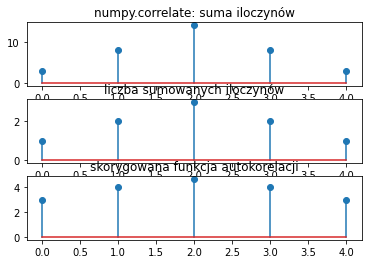

In [ ]:
x = np.array([1, 2, 3])
N = len(x)
norm_ak = np.hstack((np.arange(1,N+1,1),np.arange(N-1,0,-1)))
ak  = np.correlate(x,x,'full')
ak_z_korekta  = ak/norm_ak
plt.subplot(3,1,1)
plt.stem(ak)
plt.title('numpy.correlate: suma iloczynów')
plt.subplot(3,1,2)
plt.stem(norm_ak)
plt.title('liczba sumowanych iloczynów')
plt.subplot(3,1,3)
plt.stem(ak_z_korekta)
plt.title('skorygowana funkcja autokorelacji')
plt.show()

## Zadanie: estymacja parametrów procesu AR
* Wygeneruj 2000 próbek sygnału z modelu AR o parametrach $a = [0.9, -0.6]$, $\sigma^2=4$
* Oblicz funkcję autokorelacji tego sygnału wraz z korektą na liczbę sumowanych wyrazów
* Oblicz parametry zgodnie ze wzorami z poprzedniego paragrafu dla modelu rzędu 2. (wypisz konkretną postać wzorów analitycznie a następnie zaimplementuje je)
wskazówka: <tt>R[0]=ak[N-1]</tt>
* Wypisz parametry prawdziwe i estymowane.
* Sprawdź jak wpływa długość sygnału na dokładność estymaty (uruchom program kilka razy dla każdej z badanych długości sygnału)

In [ ]:
#wspolczynniki modelu AR 
a = np.array([0.9, -0.6])
sigma = 2
N = 200
x = np.zeros(N);

#generujemy realizacje procesu
for i in range(2,N):
    x[i] = a[0]*x[i-1] + a[1]*x[i-...] + ...

plt.subplot(2,1,1)
plt.plot(x)
plt.xlabel('numer próbki')
plt.title('wygenerowany sygnal')

plt.subplot(2,1,2)
ak = np.correlate(x,x,mode='full')
# ak nieobciążona:
norm_ak = np.hstack()
ak /= norm_ak
m = ... # przesunięcia
plt.plot(m, ak)
plt.xlabel('przesunięcie m')
plt.title('funkcja autokorelacij sygnalu x')

R=ak[N-1:]
r0=R[0]
r1=R[1]
r2=R[2]

# estymujemy wspolczynniki modelu na podstawie funkncji autokorelacji

a2 = (r1**2 - r0*r2 )/(r1**2 - r0**2)
a1 = (r1*r0 - r1*r2 )/(r0**2 - r1**2)
s_2 = r0 - a1*r1 - a2*r2

print('prawdziwe wspolczynniki')
print(  a[0], a[1], sigma)
print('estymowane wspolczynniki')
print( '%.3f, %.3f, %.3f'%(a1,  a2, s_2**0.5))

plt.show()

Zwróćmy uwagę na to, że czym większe przesunięcie $m$ tym mniej jest punktów, z których estymowana jest wartość oczekiwana i większa jest niepewność tej estymaty. 

### Estymacja parametrów dla modelu rzędu $p$
Wyżej zaprezentowany algorytm można uogólnić na modelu rzędu $p$. Estymację parametrów metodą Y-W można zaimplementować np. tak:

In [ ]:
def parametryAR(x,p):
    '''funkcja estymująca parametry modelu AR 
    argumenty:
    x- sygnał
    p - rząd modelu
    f. zwraca:
    a - wektor współczynników modelu
    epsilon - estymowana wariancja szumu

    funkcja wymaga zaimportowania modułu numpy as np
    '''
    N = len(x)
    ak = np.correlate(x,x,mode='full')
    norm_ak = np.hstack((np.arange(1,N+1,1),np.arange(N-1,0,-1)))
    ak=ak/norm_ak
    R=ak[N-1:]
    RL  = R[1:1+p]
    RP = np.zeros((p,p))
    for i in range(p):
        aa = ak[N-1-i:N-1-i+p]
        RP[i,:] = aa
    a=np.linalg.solve(RP,RL)
    sigma = (ak[N-1] - np.sum(a*ak[N:N+p]))**0.5
    return a, sigma

## Jak znaleźć rząd modelu?

### Kryterium Akaike (AIC):

  $\mathrm{AIC}(p)= \frac{2p}{N} +\ln(V) $

$p$ - ilość parametrów modelu,

$N$ - ilość próbek sygnału,

$V$ - wariancja szumu.

Kryterium to karze za zwiększanie ilości parametrów i nagradza za zmniejszanie niewytłumaczonej wariancji.

Poniższy kod jest przykładową implementacją kryterium AIC:

In [ ]:
def kryterium_AIC(x,maksymalnyRzad):
    zakres_rzedow = range(1,maksymalnyRzad)
    N = len(x)
    AIC = np.zeros(len(zakres_rzedow))
    for p in zakres_rzedow:
        a,sigma = parametryAR(x,p)
        AIC[p-1] = ...
        print( 'p:', p, ' a:',a,' sigma: ',sigma)
    return AIC

Zobaczmy jak działa to na przykładowym syganle AR:

In [ ]:
from numpy.fft import fft, fftshift
#wspolczynniki modelu AR 
a = np.array([0.9, -0.7])
sigma = 2
N = 600 # liczba próbek
x = np.zeros(N); # miejsce na realizację procesu AR
#generujemy realizacje procesu
for i in range(2,N):
    x[i]=a[0]*x[i-1]+a[1]*x[i-2] +sigma*np.random.randn()

plt.subplot(2,1,1)
plt.plot(x)
plt.title('wygenerowany sygnal')
plt.subplot(2,1,2)

AIC = kryterium_AIC(x,6)
plt.plot(range(1,len(AIC)+1),AIC)
plt.title('Kryterium AIC')
plt.xlabel('rząd modelu')
plt.ylabel('AIC')
plt.show()


## Widmo modelu AR: teoria
### Przypomnienie teorii z wykładu: transformata Z

Transformata Z jest zdefiniowana tak:

  $X(z) = Z\lbrace x[n]\rbrace  = \sum _{n=0}^\infty {x[n]z^{-n}}$

gdzie $z=Be^{i \phi }$ jest liczbą zespoloną. 

Zauważmy, że dyskretna transformata Fouriera jest szczególnym przypadkiem tej transformaty - wystarczy podstawić: 
 * $B=1/N$ i 
 * $\phi = - 2 \pi k/ N $ 

### Własności transformaty Z

Transformata ta jest liniowa tzn.

  $\mathrm{Z}\lbrace a_1x_1[n] +a_2x_2[n]\rbrace =a_1X_1(z)+a_2X_2(z)$

jak ją policzyć od sygnału przesuniętego w czasie to:

  $\mathrm{Z}\lbrace x[n-k]\rbrace  = z^{-k}X(z)$

dla impulsu:

  $\mathrm{Z}\lbrace \delta [n]\rbrace =1$

więc

  $\mathrm{Z}\lbrace \delta [n-n0]\rbrace  = z^{-n0} $

Stosując tą transfomatę do procesu AR dostajemy:

  $\mathrm{Z}\lbrace  x[n] + a_1 x[n-1] + \dots + a_p x[n-p]\rbrace  = (1 + a_1 z^{-1} + \dots + a_p z^{-p})X(z)$
  
  $=A(z)X(z)$
  

### Wyznaczenie widma modelu AR
Widmo modelu można wyliczyć analitycznie znając jego współczynniki:
Przepisujemy równanie modelu:

  $x_t = \sum _{i=1}^p a_i x_{t-i} +\epsilon _t$

  $\sum _{i=0}^p a_i x_{t-i} =\epsilon _t$

biorąc transformaty $Z$ obu stron mamy równanie algebraiczne:
  
  $A(z)X(z) =E(z)$

  $X(z)=A^{-1}(z) E(z)=H(z) E(z)$

Stąd widmo:

  $S(z) = X(z)X^*(z)=H(z) E(z) *(H(z) E(z))^* = H(z) E(z) E(z)^* H(z)^*= H(z)VH^*(z)$
  
Podstawiając $z= e^{- 2 i \pi \frac{f}{Fs}  }$ możemy uzyskać widmo modelu jako funkcję częstości $f$ ($Fs$-częstość próbkowania).

  $S(f) = X(f)X^*(f)=H(f)VH^*(f)$

## Oblicznie widma modelu: praktyka
Najpierw rozważmy konkretny przykład. 

Niech model będzie rzędu $p=2$ i ma współczynniki $a_1 = 0.9, a_2 = -0.6$ i $\sigma_{\varepsilon} = 2$. Wyliczamy wartości funkcji (zmieniamy znaki przy $a_n$ bo przenosimy je na prawą stronę równania modelu): $A(z) = 1 - a_1 z^{-1} - a_2 z^{-2}$ dla $z = e^{i 2 \pi* \frac{f}{Fs}}$:

In [ ]:
a=[0.9, -0.6]
sigma_eps = 2
Fs = 100
f=np.arange(0,Fs/2,0.1)
z=np.exp(...)
# dla zadanego modelu
A=1 - a[0]*... - ...

Następnie obliczamy odwrotność $A$:

In [ ]:
H=1./A

i obliczamy widmo:

In [ ]:
Sp=H*...
Sp = Sp.real

Możemy je wykreślić w funkcji częstości $\omega$.

In [ ]:
plt.plot(f,Sp )
plt.show()

Operacje te możemy uogólnić i zaimplementować  jako funkcję do obliczania widma modelu zadanego przez parametry:

In [ ]:
def widmoAR(parametry_a, sigma, N_punktow, Fs):
    f = np.linspace(0,Fs/2,N_punktow)
    z = np.exp(1j*2*np.pi*f/Fs)
    A = -1 * np.ones(N_punktow) + 1j*np.zeros(N_punktow)
    for i in range(len(parametry_a)):
        A += parametry_a[i]*z**(-(i+1))
    H = 1./A
    Sp = H*H.conj()* sigma**2 # widmo
    Sp = Sp/Fs #gęstość widmowa
    Sp = Sp.real
    return f, Sp

## Zadanie
Proszę:
* Wygenerować realizację modelu AR $a = \{0.6, -0.7, 0.3, -0.25\}, \quad \sigma_{\varepsilon} = 2$

In [ ]:
def generujAR(a, sigma_eps, N):
    x=np.zeros(N)
    rzad = len(a)
    for i in range(rzad,N):
        for p in range(len(a)):
            x[i] += a[p]*x[i-(p+1)]
        x[i] += sigma_eps*np.random.randn()
    return x

* Obliczyć widmo dla tego modelu
* Wyestymować parametry modelu na podstawie sygału, zakładając, że rząd jest p = 3,4,5,6
* Obliczyć widmo dla wyestymowanego modelu
* Wykreślić widma prawdziwego modelu i modeli estymowanych

In [ ]:
#wspolczynniki modelu AR 
a = np.array([0.6, -0.7, 0.3, -0.25])
sigma = 2
Fs = 100 # [Hz]
# obliczanie widma z modelu
f, Sp = widmoAR(a, sigma,200,Fs)

#generujemy realizacje procesu
N=600
x = generujAR(a, sigma, N)

# estymujemy wspolczynniki modelu metodą Yula-Walkera
# obliczamy widmo dla estymowanego modelu
...

plt.plot(f,Sp)
plt.xlabel('Częstość [Hz]')
plt.legend(('p = 3','p = 4','p = 5','p = 6','prawdziwy'))
plt.title('widmo z modelu')
plt.show()

## Zadanie

Dla modelu z poprzedniego ćwiczenia proszę wygenerować realizację sygnału długości 1000 punktów. Proszę porównać widma:
* prawdziwe, obliczone z prawdziwych parametrów  modelu
* obliczone z estymowanego modelu
* obliczone przez periodogram
* obliczone metodą Welcha 

In [ ]:
#wspolczynniki modelu AR 
a = np.array([0.3, 0.2, 0.5, -0.25 ,-0.3])
epsilon = 2
N = 1000
Fs = 100
# obliczanie widma z modelu
f, P_model = widmoAR(a,epsilon,N,Fs)

#generujemy realizacje procesu
x = generujAR(a, epsilon, N)

# estymujemy wspolczynniki modelu metodą Yula-Walkera
# obliczamy widmo dla estymowanego modelu
a_est,epsilon_est = ...
f, P_est = ...

okno = np.blackman(N)                  
f_periodogram, P_periodogram = periodogram(x, okno , Fs)

okno_welch = np.blackman(N/20)
f_welch, P_welch = welch...
               


plt.plot(f_periodogram, P_periodogram)
plt.plot(f,P_model)
plt.plot(f,P_est)
plt.plot(f_welch, P_welch )
plt.legend(('period','model-teoret','model-est','Welch'))

#plt.legend(('prawdziwy','estymowany z AR','periodogram','Welch','mtm'))

print( 'enenrgia sygnału: ', np.sum(x**2 * 1/Fs))
print( 'enenrgia spektrum AR',np.sum(P_model))
print( 'enenrgia est',np.sum(P_est))
print( 'enenrgia welch',np.sum(P_welch)*len(okno)/len(okno_welch))
print( 'enenrgia period',np.sum(P_periodogram))
plt.show()


### Zadanie: widmo EEG
Teraz, kiedy umiemu już estymować widma różnymi metodami proszę pobawić się prawdziwymi synałami. 
* Przykładowy sygnał EEG, zawierający rytm alfa. 2 kanały liczb  dtype='float64' i częstość próbkowania 128 Hz: znajduje się tu: 
[https://www.fuw.edu.pl/~jarekz/SYGNALY/alfa.bin tu].
* Proszę zapisać ten sygnał w swoim bieżącym katalogu, wczytać go i oszacować widmo metodą AR i metodą Welcha.

## Co z tego musimy zapamiętać:
* widmo sygnału stochastycznego estymujemy, a nie obliczamy
* są dwie klasy technik:
-- nieparametryczne - **widmo estymujemy** bezpośrednio dla sygnału np. metodą periodogram, Welcha, wielookienkową 
-- parametryczne: najpierw **estymujemy model** opisujący dane, a nstępnie dla modelu **obliczamy** widmo
> ### Ogólny schemat estymowania widma metodą AR
> W praktyce musimy najczęściej estymować widmo mając dany tylko sygnał. 
> Wówczas powinniśmy postąpić według następującego algorytmu:
> * oszacować rząd modelu np. przy pomocy kryterium Akaikego
> * wyestymować parametry modelu
> * obliczyć widmo dla estymowanego modelu